# Boom Bikes: Demand Prediction

### Linear regression model for the prediction of demand for shared bikes.

## Data Understanding

In [248]:
# Import all dependencies
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [249]:
# Suppress warning
import warnings
warnings.filterwarnings(action='ignore')

In [250]:
# Load the data
rides = pd.read_csv('day.csv')

# Look at the top 5 data
rides.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [251]:
# Look at the data shape to know row and column size
rides.shape

(730, 16)

---

## Data Cleaning

Identify columns with large number of null values

In [252]:
# Look for the null % for each columns
round(rides.isnull().sum()/len(rides.index), 2)*100

instant       0.0
dteday        0.0
season        0.0
yr            0.0
mnth          0.0
holiday       0.0
weekday       0.0
workingday    0.0
weathersit    0.0
temp          0.0
atemp         0.0
hum           0.0
windspeed     0.0
casual        0.0
registered    0.0
cnt           0.0
dtype: float64

As seen there are no columns with null values. Hence no handling required

### Based on the details provided we can drop below
- instant: It's just the record index and would not add value
- dteday: It's the date of transaction. The required details like year, month, day is already available. 
- casual + registered: cnt is the sum of these 2

In [253]:
# Create an array of all columns that can be dropped
drop_columns = ['instant', 'dteday', 'casual', 'registered']

# Drop columns in place
rides.drop(drop_columns, axis=1, inplace=True)
rides.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


### Map the categorical variables with text values

_Season_

In [254]:
# Let us map the season with the corresponding name to make it more clear
season = {1:'spring', 2: 'summer', 3: 'fall', 4: 'winter'}
rides['season'] = rides['season'].apply(lambda x: season[x])
rides['season'].value_counts()

fall      188
summer    184
spring    180
winter    178
Name: season, dtype: int64

_Months_

In [255]:
# Let us map the month with corresponding name to make it more clear
months = {1: 'jan', 
          2: 'feb', 
          3: 'mar', 
          4: 'apr', 
          5: 'may', 
          6: 'jun', 
          7: 'jul', 
          8: 'aug',
          9: 'sep',
          10: 'oct',
          11: 'nov',
          12: 'dec'
         }
rides['mnth'] = rides['mnth'].apply(lambda x: months[x])
rides['mnth'].value_counts()

jan    62
mar    62
may    62
jul    62
aug    62
oct    62
dec    62
apr    60
jun    60
sep    60
nov    60
feb    56
Name: mnth, dtype: int64

_Weather_

In [256]:
# Let us map the weather with corresponding name to make it more clear
weather = {1: 'clear', 2: 'mist', 3: 'snow', 4: 'rain'}
rides['weathersit'] = rides['weathersit'].apply(lambda x: weather[x])
rides['weathersit'].value_counts()

clear    463
mist     246
snow      21
Name: weathersit, dtype: int64

_Weekday_

In [257]:
# Let us map the weekday with corresponding name to make it more clear
weekday = {0: 'sunday', 1: 'monday', 2: 'tuesday', 3: 'wednesday', 4: 'thursday', 5: 'friday', 6: 'saturday' }
rides['weekday'] = rides['weekday'].apply(lambda x: weekday[x])
rides['weekday'].value_counts()

saturday     105
sunday       105
monday       105
tuesday      104
thursday     104
friday       104
wednesday    103
Name: weekday, dtype: int64

In [258]:
# Let us look at the data now
rides.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,spring,0,jan,0,saturday,0,mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sunday,0,mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,monday,1,clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,tuesday,1,clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,wednesday,1,clear,9.305237,11.46350,43.6957,12.522300,1600


## Data Analysis

### Univariate Analysis

([0, 1, 2], [Text(0, 0, 'mist'), Text(1, 0, 'clear'), Text(2, 0, 'snow')])

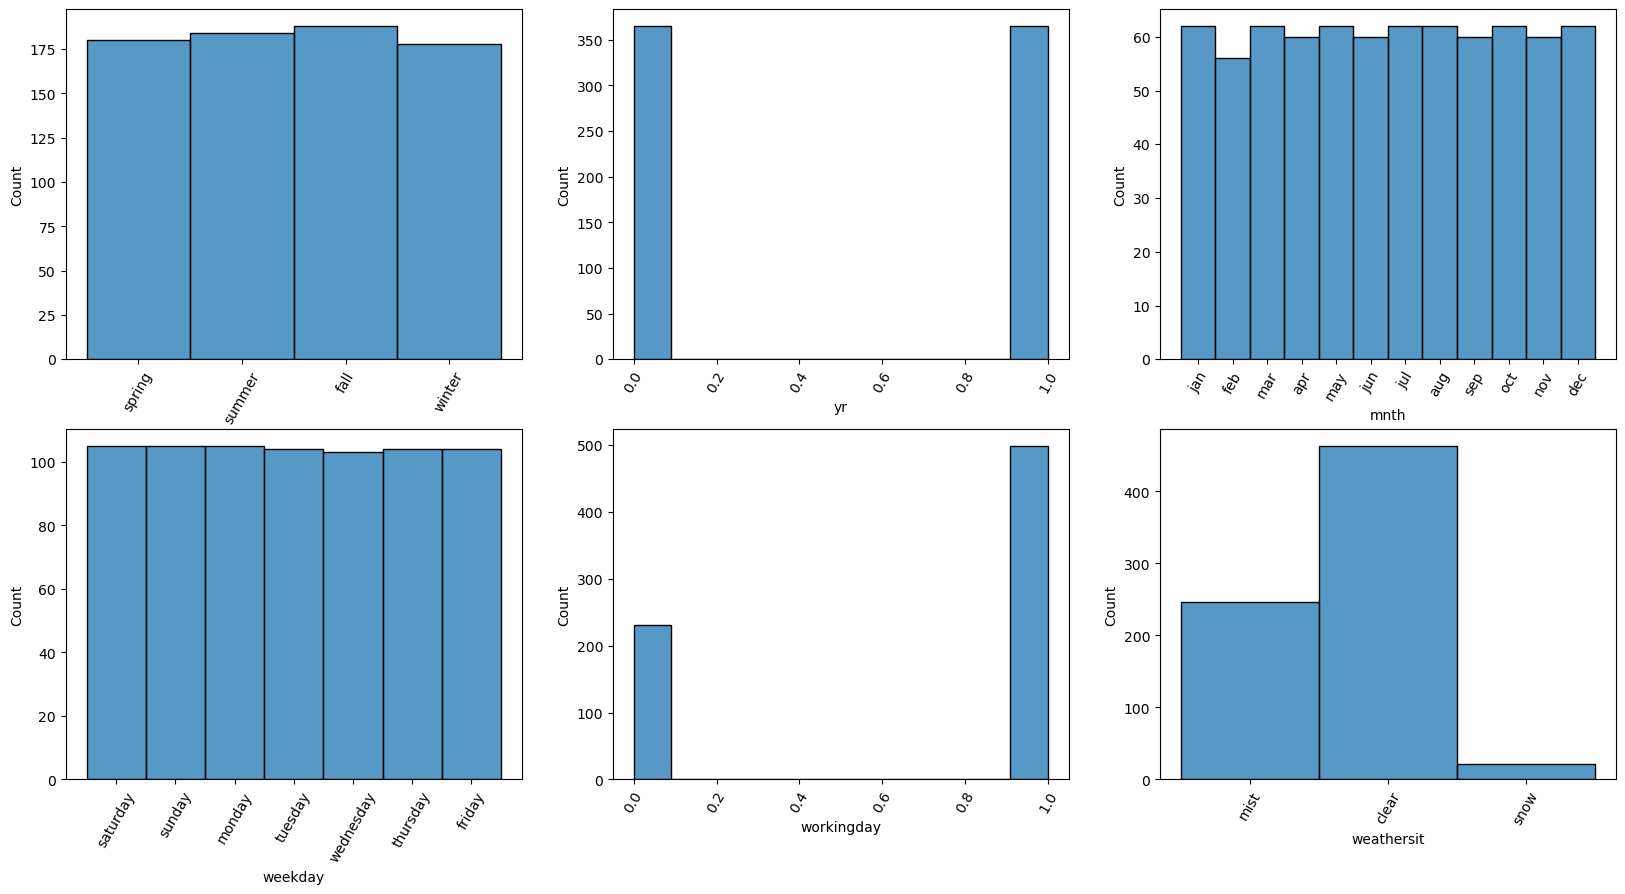

In [259]:
plt.figure(figsize=(20,10))
plt.subplot(2,3,1)
# Histplot of season
sns.histplot(data=rides, x="season")
plt.xticks(rotation=60)
plt.subplot(2,3,2)
# Histplot of year
sns.histplot(data=rides, x="yr")
plt.xticks(rotation=60)
plt.subplot(2,3,3)
# Histplot of months
sns.histplot(data=rides, x="mnth")
plt.xticks(rotation=60)
plt.subplot(2,3,4)
# Histplot of weekdays
sns.histplot(data=rides, x="weekday")
plt.xticks(rotation=60)
plt.subplot(2,3,5)
# Histplot of working day/holiday
sns.histplot(data=rides, x="workingday")
plt.xticks(rotation=60)
plt.subplot(2,3,6)
# Histplot of weather
sns.histplot(data=rides, x="weathersit")
plt.xticks(rotation=60)

#### As we can see in the plots above:
- More rides were made on working days
- Rides were the least when snowing

### Bi-Variate Analysis

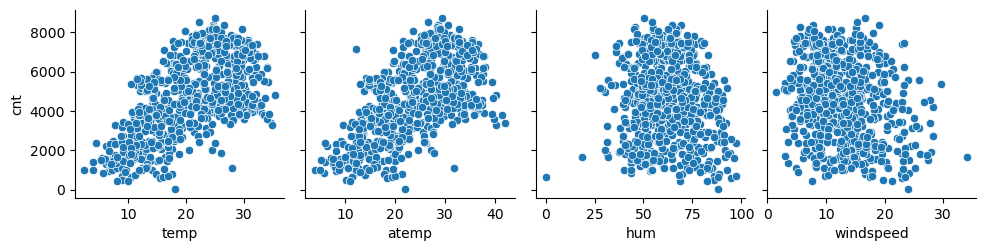

In [262]:
sns.pairplot(data=rides, x_vars=['temp', 'atemp', 'hum', 'windspeed'], y_vars=['cnt'])

<Axes: >

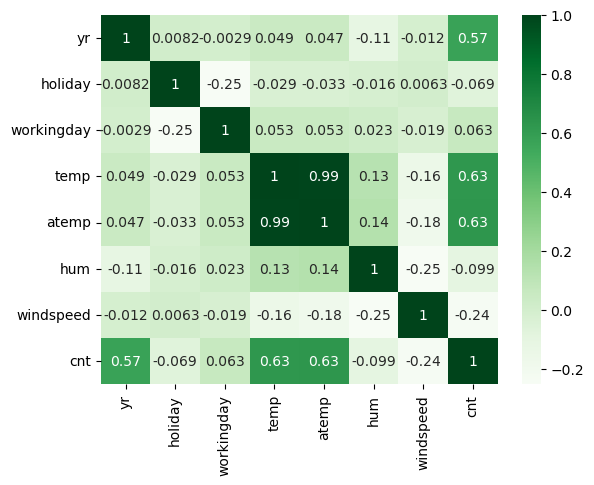

In [263]:
sns.heatmap(rides.corr(), annot=True, cmap="Greens")

#### Few observations:
- temp and atemp seems to have linear relationship based on above plots
- temp and atemp have correlation

## Data Preparation

#### Encode variables - Create dummies

In [264]:
# Convert all categorical columns into dummies. This inclues season, mnth, weekday and weathersit
rides = pd.get_dummies(rides, columns=['season', 'mnth', 'weekday', 'weathersit'], drop_first=True)
rides.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,mnth_oct,mnth_sep,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_mist,weathersit_snow
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,0,1,0,0,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,0,1,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,1,0,0


## Model Building
This inclues below steps
- Divide data into train and test data
- Perform scaling (Min-Max)
- Divide the data into X (independent) and y (dependent)
- Perform Linear Regression
- Analyze modeal

#### Train-Test Split

In [265]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(rides, train_size = 0.7, test_size = 0.3, random_state = 100)

#### Scaling of continuous variables

In [266]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
continuous_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# For train data we need to do both fit and transform as the model needs to learn first and then transform
train[continuous_vars] = scaler.fit_transform(train[continuous_vars])

# For test data we only do transform as the model already has learnt in the above step.
test[continuous_vars] = scaler.transform(test[continuous_vars])

In [267]:
train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_spring,season_summer,...,mnth_oct,mnth_sep,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_mist,weathersit_snow
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0.864243,0,0,...,1,0,0,0,0,0,1,0,0,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,...,0,0,0,1,0,0,0,0,1,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,...,0,0,0,1,0,0,0,0,1,0


#### Split into dependent (y) and independent (X) variables

In [268]:
# 'cnt' is our dependent variable. So we add all independent variables into an array
independent_columns= [i for i in rides.columns if i != 'cnt']

X_train = train[independent_columns]
y_train = train['cnt']

X_test = test[independent_columns]
y_test = test['cnt']

In [269]:
# Look at the train set
X_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_spring,season_summer,season_winter,...,mnth_oct,mnth_sep,weekday_monday,weekday_saturday,weekday_sunday,weekday_thursday,weekday_tuesday,weekday_wednesday,weathersit_mist,weathersit_snow
653,1,0,1,0.509887,0.501133,0.575354,0.300794,0,0,1,...,1,0,0,0,0,0,1,0,0,0
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0,0,0,...,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,1,0,0,...,0,0,0,1,0,0,0,0,1,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,1,0,0,...,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [270]:
y_train.head()

653    0.864243
576    0.827658
426    0.465255
728    0.204096
482    0.482973
Name: cnt, dtype: float64

### Linear Regression

#### Using statsmodel to analyze the model

In [271]:
# Let us create a function that accepts X and y data and returns the model
def stats_linear_regression(X, y):
    X_sm = sm.add_constant(X)
    lms = sm.OLS(y, X_sm).fit()
    return lms

In [272]:
# Let us first check the model with all features
lms = stats_linear_regression(X_train, y_train)
print(lms.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     99.96
Date:                Tue, 12 Sep 2023   Prob (F-statistic):          8.42e-181
Time:                        11:03:54   Log-Likelihood:                 528.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     481   BIC:                            -875.3
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.2452      0.03

*Clearly we have a lot of features that are irrelevant based on their p values though we have a decent r2 value.*    

#### Let us try and optimize the model manually first. Here we will optimize by
- remove those features that has high p value and high VIF value first 
- then remove those with high p value
- then remove those with high VIF value

#### VIF for all features

In [273]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a function to print the VIF values of the variables for the train data
def vif(features):
    X_vif = X_train[features]
    vif_data = pd.DataFrame()
    vif_data['feature'] = X_vif.columns
    vif_data['vif'] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(len(X_vif.columns))]

    print(vif_data)

In [274]:
# let us check the VIF for all features
vif(independent_columns)

              feature        vif
0                  yr   1.059159
1             holiday   4.509345
2          workingday  85.595596
3                temp  67.118416
4               atemp  56.094759
5                 hum   2.054619
6           windspeed   1.299464
7       season_spring  10.801852
8       season_summer   8.312637
9       season_winter   9.520373
10           mnth_aug   6.544398
11           mnth_dec   5.680311
12           mnth_feb   4.390822
13           mnth_jan   5.902714
14           mnth_jul   5.703695
15           mnth_jun   2.883910
16           mnth_mar   3.473939
17           mnth_may   2.243270
18           mnth_nov   6.795753
19           mnth_oct   6.587437
20           mnth_sep   4.960189
21     weekday_monday   1.982813
22   weekday_saturday  19.720278
23     weekday_sunday  18.352174
24   weekday_thursday   1.829571
25    weekday_tuesday   1.797424
26  weekday_wednesday   1.941067
27    weathersit_mist   1.601133
28    weathersit_snow   1.299277


#### Will remove that variable which has high VIF and high p value
#### Since atemp has high p value, let us first remove it

In [275]:
# Let us create a function that will give the VIF after removing mentioned features
def remove_and_check_vif(features):
    independent_columns_minus = [i for i in independent_columns if i not in features]
    vif(independent_columns_minus)

In [276]:
features_to_remove = ['atemp']
remove_and_check_vif(features_to_remove)

              feature        vif
0                  yr   1.058134
1             holiday   4.499705
2          workingday  85.578244
3                temp   7.118264
4                 hum   2.052318
5           windspeed   1.239789
6       season_spring  10.785986
7       season_summer   8.289339
8       season_winter   9.501176
9            mnth_aug   6.426366
10           mnth_dec   5.680304
11           mnth_feb   4.390483
12           mnth_jan   5.900971
13           mnth_jul   5.664138
14           mnth_jun   2.829939
15           mnth_mar   3.471404
16           mnth_may   2.222095
17           mnth_nov   6.795573
18           mnth_oct   6.586439
19           mnth_sep   4.940196
20     weekday_monday   1.960736
21   weekday_saturday  19.717912
22     weekday_sunday  18.350060
23   weekday_thursday   1.814784
24    weekday_tuesday   1.787713
25  weekday_wednesday   1.933325
26    weathersit_mist   1.600990
27    weathersit_snow   1.291561


#### season_spring also has higher VIF and higher p value. Let us remove it

In [277]:
features_to_remove = ['atemp', 'season_spring']
remove_and_check_vif(features_to_remove)

              feature        vif
0                  yr   1.057488
1             holiday   3.908190
2          workingday  70.924146
3                temp   7.009499
4                 hum   2.049273
5           windspeed   1.231983
6       season_summer   4.730630
7       season_winter   6.075476
8            mnth_aug   5.113072
9            mnth_dec   5.639981
10           mnth_feb   3.838552
11           mnth_jan   5.226233
12           mnth_jul   4.645835
13           mnth_jun   2.735839
14           mnth_mar   3.117996
15           mnth_may   2.217149
16           mnth_nov   6.791668
17           mnth_oct   6.586415
18           mnth_sep   4.231022
19     weekday_monday   1.959992
20   weekday_saturday  16.165304
21     weekday_sunday  15.157193
22   weekday_thursday   1.814370
23    weekday_tuesday   1.787711
24  weekday_wednesday   1.932633
25    weathersit_mist   1.599188
26    weathersit_snow   1.285883


#### Let us remove those with high p value

In [278]:
features_to_remove = ['atemp', 
                      'holiday',
                      'season_spring',
                      'weekday_wednesday',
                      'weekday_tuesday',
                      'weekday_thursday',
                      'weekday_monday',
                      'mnth_oct',
                      'mnth_nov',
                      'mnth_may',
                      'mnth_mar',
                      'mnth_jun',
                      'mnth_jul',
                      'mnth_jan',
                      'mnth_feb',
                      'mnth_dec',
                      'mnth_aug',
                      'season_summer',
                      'weekday_sunday',
                      'hum'
                     ]
remove_and_check_vif(features_to_remove)

            feature       vif
0                yr  2.017742
1        workingday  4.024440
2              temp  4.557708
3         windspeed  3.355425
4     season_winter  1.281704
5          mnth_sep  1.153019
6  weekday_saturday  1.687298
7   weathersit_mist  1.515945
8   weathersit_snow  1.083031


#### We will now try our model with only above 9 features

In [279]:
X_train_final = X_train[['yr', 
                         'workingday', 
                         'temp', 
                         'windspeed',
                         'season_winter',
                         'mnth_sep',
                         'weekday_saturday',
                         'weathersit_mist',
                         'weathersit_snow'
                        ]]
X_train_final_sm = sm.add_constant(X_train_final)
lms = sm.OLS(y_train, X_train_final_sm).fit()
print(lms.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     240.1
Date:                Tue, 12 Sep 2023   Prob (F-statistic):          3.19e-175
Time:                        11:04:27   Log-Likelihood:                 464.84
No. Observations:                 510   AIC:                            -909.7
Df Residuals:                     500   BIC:                            -867.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0859      0.020  

####  Looking at some key statistics from the summary
The values we are concerned with are - 
1. The coefficients and significance (p-values)
2. R-squared
3. F statistic and its significance

1. _Coeffecients of the 9 features and the constant is as in the summary above._  
They all have very high significance as p is 0

2. _R-squared is 0.812 which is a decent value._

3. _F statistics has a very low p value (close to 0), meaning that that the model fit is statistically significant_

---

## Model Evaluation

### Linearity
We have assumed linearity based on the pair plots 

### No multicolinearity in features

We have used VIF to check multi-colinearity. VIF < 5 is considered a good value to indicate no colinearity. All our features have less than 5 value

### No autocorrelation in residuals
Durbin-Watson test can be used for this. Value close to 2 suggest there is no autocorrelation.  
We have got a value of 1.9

### Distribution of the error terms
We need to check if the error terms are also normally distributed (which is infact, one of the major assumptions of linear regression), let us plot the histogram of the error terms and see what it looks like.

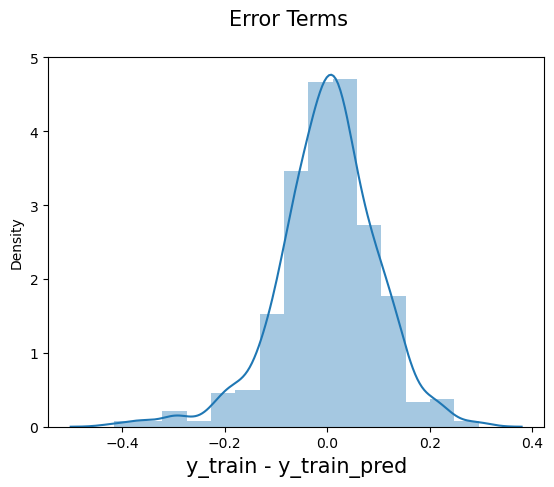

In [280]:
y_train_pred = lms.predict(X_train_final_sm)
res = (y_train - y_train_pred)
fig = plt.figure()
sns.distplot(res, bins = 15)
fig.suptitle('Error Terms', fontsize = 15)                  # Plot heading 
plt.xlabel('y_train - y_train_pred', fontsize = 15)         # X-label
plt.show()

### Homoscedacity
In the graph below we do not see any definite patter which confirms homoscedacity

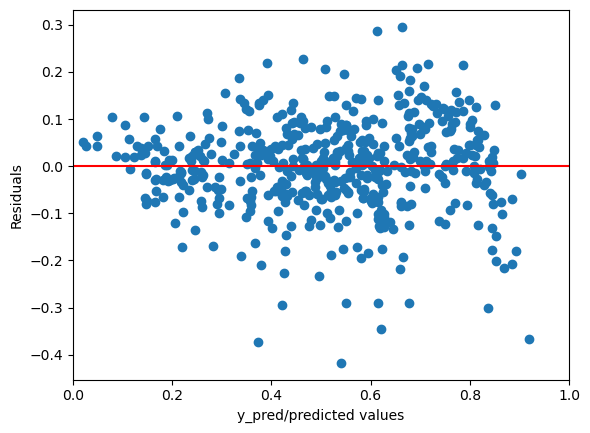

In [281]:
plt.scatter(y_train_pred, res)
plt.xlim(0,1)
plt.xlabel('y_pred/predicted values')
plt.ylabel('Residuals')
plt.axhline(y = 0, color = 'r', linestyle = '-')

## Prediction on the test set
Now that you have fitted a regression line on your train dataset, it's time to make some predictions on the test data. For this, you first need to add a constant to the `X_test` data like you did for `X_train` and then you can simply go on and predict the y values corresponding to `X_test` using the `predict` attribute of the fitted regression line.

In [282]:
# We will take only the final selected features out of all the available features
X_test_final = X_test[['yr', 
                       'workingday', 
                       'temp', 
                       'windspeed',
                       'season_winter',
                       'mnth_sep',
                       'weekday_saturday',
                       'weathersit_mist',
                       'weathersit_snow'
                        ]]
X_test_final_sm = sm.add_constant(X_test_final)
y_predicted = lms.predict(X_test_final_sm)

In [283]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_predicted)
r_squared = r2_score(y_test, y_predicted)
print('Mean_Squared_Error :' ,mse)
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.010779040907007226
r_square_value : 0.7730527950403363


---
### We have a r squared value of 0.77 for the test data which is inside ~5% range of what we got for our train set. This is a reasonably decent model

---

### Using automated ways

In [284]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVR

In [285]:
# Let us first create a function that accepts the number of features and return a model
def linear_model(n_features_to_select, features_to_remove = []):
    required_columns = [i for i in X_train.columns if i not in features_to_remove]
    X_train_optimal = X_train[required_columns]
    # Use RFE
    estimator = SVR(kernel='linear')
    selector = RFE(estimator,n_features_to_select=n_features_to_select, step=1)
    selector = selector.fit(X_train_optimal, y_train)
    X_train_optimal_RFE = X_train[X_train_optimal.columns[selector.support_]]
    lms = stats_linear_regression(X_train_optimal_RFE, y_train)
    return lms

#### Let us try with different values of features to select and compare

#### There is no significant drop in r squared value when we drop the features upto 13 from 28

In [286]:
features_to_remove = []
lms = linear_model(13, features_to_remove)
print(lms.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     204.8
Date:                Tue, 12 Sep 2023   Prob (F-statistic):          9.13e-190
Time:                        11:05:36   Log-Likelihood:                 510.54
No. Observations:                 510   AIC:                            -993.1
Df Residuals:                     496   BIC:                            -933.8
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2389      0.027     

#### Based on manual analysis, we know atemp has high p value and  VIF. So drop it

In [287]:
features_to_remove = ['atemp']
lms = linear_model(13, features_to_remove)
print(lms.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.840
Method:                 Least Squares   F-statistic:                     207.2
Date:                Tue, 12 Sep 2023   Prob (F-statistic):          7.61e-191
Time:                        11:05:40   Log-Likelihood:                 513.11
No. Observations:                 510   AIC:                            -998.2
Df Residuals:                     496   BIC:                            -938.9
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.2586      0.028     

#### Let us check the VIF now

In [288]:
# After trying with few combinations below set of variables seem to give good result
features_to_remove = ['workingday',
                      'atemp',
                      'hum',
                      'season_spring',
                      'mnth_dec',
                      'mnth_feb',
                      'mnth_jul',
                      'mnth_jun',
                      'mnth_mar',
                      'mnth_may',
                      'mnth_nov',
                      'weekday_monday',
                      'weekday_saturday',
                      'weekday_sunday',
                      'weekday_thursday',
                      'weekday_tuesday',
                      'weekday_wednesday'
                     ]
remove_and_check_vif(features_to_remove)

            feature       vif
0                yr  2.040123
1           holiday  1.040053
2              temp  5.149768
3         windspeed  3.344672
4     season_summer  1.895788
5     season_winter  2.007210
6          mnth_aug  1.605932
7          mnth_jan  1.224021
8          mnth_oct  1.598457
9          mnth_sep  1.344088
10  weathersit_mist  1.537661
11  weathersit_snow  1.094581


In [289]:
features_to_remove = ['atemp', 'hum']
lms = linear_model(13, features_to_remove)
print(lms.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     199.7
Date:                Tue, 12 Sep 2023   Prob (F-statistic):          1.70e-187
Time:                        11:05:48   Log-Likelihood:                 505.15
No. Observations:                 510   AIC:                            -982.3
Df Residuals:                     496   BIC:                            -923.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2591      0.026  

---
### Based on the above summary:
- weathersit_snow, year and temperature has highest impact on the demand
- snow impacts demand negatively: People ride less when snowing
- year impacts positively: Demand seems to be increasing with year (Time)
- temperature impacts positively: Lesser temperature not favorable for demand
---

### By removing atemp and hum and with 13 features we have a model with r-squared of 0.84 and all features have high significance

In [290]:
# We will take only the final selected features out of all the available features
X_test_final = X_test[['yr', 
                       'workingday', 
                       'temp', 
                       'windspeed',
                       'season_spring',
                       'season_winter',
                       'mnth_dec',
                       'mnth_jan',
                       'mnth_nov',
                       'mnth_sep',
                       'weekday_saturday',
                       'weathersit_mist',
                       'weathersit_snow'
                        ]]
X_test_final_sm = sm.add_constant(X_test_final)
y_predicted = lms.predict(X_test_final_sm)

In [291]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_predicted)
r_squared = r2_score(y_test, y_predicted)
print('Mean_Squared_Error :' ,mse)
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.008694505227752626
r_square_value : 0.8169416298751672


---
### We have a r squared value of 0.82 for the test data which is inside ~5% range of what we got for our train set. This is a reasonably decent model

---

## Let us try with sklearn LinearRegression

In [292]:
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

X_train_final = X_train[['yr', 
                       'workingday', 
                       'temp', 
                       'windspeed',
                       'season_spring',
                       'season_winter',
                       'mnth_dec',
                       'mnth_jan',
                       'mnth_nov',
                       'mnth_sep',
                       'weekday_saturday',
                       'weathersit_mist',
                       'weathersit_snow'
                        ]]
lm = LinearRegression()
lm.fit(X_train_final, y_train)

LinearRegression()

In [293]:
lm.score(X_train_final, y_train)

0.8395795230692186

In [294]:
lm.coef_

array([ 0.23624183,  0.05575394,  0.35763122, -0.1542559 , -0.10727478,
        0.06987568, -0.05964904, -0.06461234, -0.05780263,  0.05993261,
        0.06694144, -0.0807618 , -0.30270556])

In [295]:
lm.intercept_

0.2590958467079627

In [296]:
X_test_final = X_test[['yr', 
                       'workingday', 
                       'temp', 
                       'windspeed',
                       'season_spring',
                       'season_winter',
                       'mnth_dec',
                       'mnth_jan',
                       'mnth_nov',
                       'mnth_sep',
                       'weekday_saturday',
                       'weathersit_mist',
                       'weathersit_snow'
                        ]]
y_predicted =  lm.predict(X_test_final)

In [238]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_predicted)
r_squared = r2_score(y_test, y_predicted)
print('Mean_Squared_Error :' ,mse)
print('r_square_value :',r_squared)

Mean_Squared_Error : 0.008694505227752619
r_square_value : 0.8169416298751673


As you can see the results are same with both libraries